In [1]:
from datetime import datetime
import math
import os

from matplotlib import pyplot as plt
import pandas as pd

from qaoa_solver import QAOASolver
from utils import *

In [3]:
experiment = "test_BFGS"

conf = {
    "experiment": experiment,
    "number": 15,
    "layers": 7,
    "problem_hamiltonian": "linear_H", # for system evolution
    "cost_hamiltonian": "abs_H", # for cost evaluation
    "initial_gamma": math.pi / 3,
    "initial_beta": math.pi / 3,
    "optimizer": 'BFGS',
    "verbose": False
}

solver = QAOASolver(
    N=conf['number'],
    layers=conf['layers'],
    problem_hamiltonian=conf['problem_hamiltonian'],
    cost_hamiltonian=conf['cost_hamiltonian'],
    optimizer_method=conf['optimizer']
)

solver.run(conf)

100%|██████████| 7/7 [00:00<00:00,  0.06s/exp]


In [6]:
experiment_result_files = os.listdir(f'experiments/results/{experiment}')
experiment_results = []

for result_file in experiment_result_files:
    result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f')
    result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
    experiment_results.append(result)


df = pd.concat(experiment_results)
df['num_qubits'] = df['nx'] + df['ny']
df['problem_hamiltonian'] = df['config'].apply(lambda c: c.get('problem_hamiltonian'))
df['cost_hamiltonian'] = df['config'].apply(lambda c: c.get('cost_hamiltonian'))
df['gamma_0'] = df['config'].apply(lambda c: c.get('initial_gamma'))
df['beta_0'] = df['config'].apply(lambda c: c.get('initial_beta'))
df['experiment'] = df['config'].apply(lambda c: c.get('experiment'))
df['extended_qaoa'] = df['config'].apply(lambda c: c.get('extended_qaoa', False))
df['setup'] = df['experiment'].str.split('_').str[1:].str.join('_')
df['state_populations'] = df['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
df['solution'] = df.apply(lambda row: compute_solution(row['N']), axis=1)
df['fidelity'] = df.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)
df['gamma_0'] = df['gamma_0'].round(3)
df['beta_0'] = df['beta_0'].round(3)

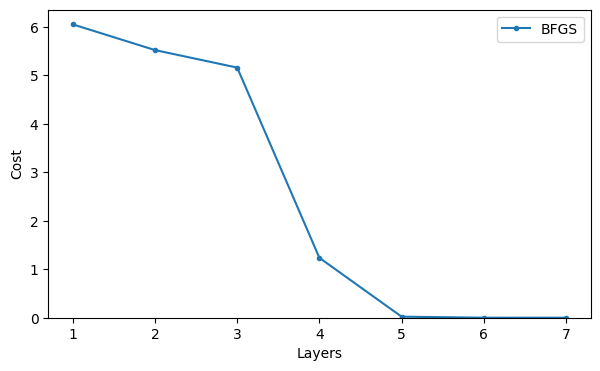

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

setups = sorted(df.setup.unique(), reverse=True)

for j, setup in enumerate(setups):
    df_j = df[df.setup == setup].copy()
    ax.plot('layers', 'cost', data=df_j, marker='.', label=setup)

ax.set_ylabel('Cost')
ax.set_xlabel('Layers');
ax.set_ylim(0);

ax.legend(loc='best');
